# Model Explicit Likelihood Inference
Infer from a cosmological model via MCMC samplers. 

In [3]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

## Inference

### Import

# CONFIG
{'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.15], 'sigma8': ['{\\sigma}_8', 0.8102, 0.15], 'b1': ['{b}_1', 1.0, 1], 'b2': ['{b}_2', 0.0, 1], 'bs2': ['{b}_{s^2}', 0.0, 1], 'bn2': ['{b}_{\\nabla^2}', 0.0, 1]}, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [10.0, 10.0, 10.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.31416 h/Mpc
mean_gxy_density: 1.000 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

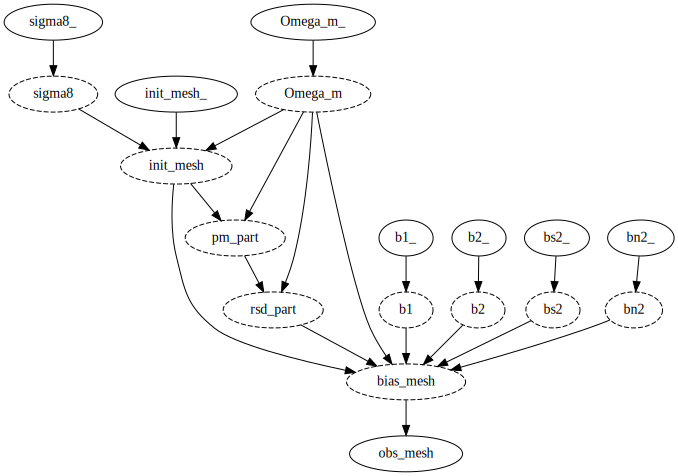

In [5]:
from montecosmo.models import pmrsd_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn
from montecosmo.models import print_config, condition_on_config_mean, default_config as config
# Build and render model
model = partial(pmrsd_model, **config)
print_config(model)

# Get fiducial parameters
fiduc_model = partial(model, trace_reparam=True)
fiduc_params = get_simulator(condition_on_config_mean(fiduc_model))(rng_seed=0)

# Condition model on observables
obs_names = ['obs_mesh']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_model = condition(model, obs_params)

# Get and vectorize relevant functionals
logp_fn = get_logp_fn(obs_model)
score_fn = get_score_fn(obs_model)
pk_vfn = jit(vmap(get_pk_fn(**config)))
param_vfn = jit(vmap(get_param_fn(**config)))
numpyro.render_model(model=partial(model, trace_reparam=True, trace_meshes=True), render_params=True)

### Run

In [7]:
num_samples, max_tree_depth, n_runs, num_chains = 256, 10, 4, 8

nuts_kernel = numpyro.infer.NUTS(
    model=obs_model,
    init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    adapt_mass_matrix=True,
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,)

mcmc = numpyro.infer.MCMC(
    sampler=nuts_kernel,
    num_warmup=num_samples,
    num_samples=num_samples, # for each run
    num_chains=num_chains,
    chain_method="vectorized",
    progress_bar=True,)